<a href="https://colab.research.google.com/github/CyrilZzz/nlp_project/blob/master/projet_nlp_3A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1eNJn7rX2OE9UKrrknmvClt3IK2cUTRjB&export=download&confirm=t'
output = 'dataset.tar.xz'

gdown.download(url, output, quiet=False)



Downloading...
From: https://drive.google.com/uc?id=1eNJn7rX2OE9UKrrknmvClt3IK2cUTRjB&export=download&confirm=t
To: /content/dataset.tar.xz
100%|██████████| 334M/334M [00:05<00:00, 59.9MB/s]


'dataset.tar.xz'

In [ ]:
import tarfile

with tarfile.open('dataset.tar.xz') as f:
    f.extractall('.')

In [ ]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 25.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np


In [ ]:
import re
from spacy.lang.en import English

spacy_tokenizer = English().tokenizer

def clean_str(string, tokenizer=None):
    """
    Parts adapted from https://github.com/Shawn1993/cnn-text-classification-pytorch/blob/master/mydatasets.py
    """
    assert isinstance(string, str)
    string = string.replace("<br />", "")
    string = re.sub(r"[^a-zA-Z0-9.]+", " ", string)

    return (
        string.strip().split()
        if tokenizer is None
        else [t.text for t in tokenizer(string.strip())]
    )

def pad(max_len, seq, token):
	assert isinstance(seq, list)
	abs_len = len(seq)
	if abs_len > max_len:
		seq = seq[:max_len]
	else:
		seq += [token] * (max_len - abs_len)
	return seq

def fgws_preprocess(sentence):
	sentence = clean_str(sentence)
	sentence = pad(200, sentence, "<pad>")
	sentence = ' '.join(sentence)
	return sentence

In [ ]:
df = pd.read_csv("/content/original/imdb/roberta/pwws/roberta-base-imdb_pwws.csv")
df

,original_text,perturbed_text,original_score,perturbed_score,original_output,perturbed_output,ground_truth_output,num_queries,result_type
0,[[Once]] again Mr. Costner has [[dragged]] out...,[[erstwhile]] again Mr. Costner has [[haul]] o...,0.002336,0.669255,0,1,0,1047,Successful
1,This is an example of why the majority of acti...,This is an example of why the majority of acti...,0.000916,0.591362,0,1,0,2281,Successful
2,"First of all I hate those moronic rappers, who...","First of all I hate those moronic rappers, who...",0.000837,0.565255,0,1,0,1573,Successful
3,Not even the Beatles could write songs everyon...,Not even the Beatles could write songs everyon...,0.001466,0.759977,0,1,0,2339,Successful
4,Brass pictures (movies is not a fitting word f...,Brass pictures (movies is not a fitting word f...,0.005774,0.812805,0,1,0,1593,Successful
...,...,...,...,...,...,...,...,...,...
9995,This movie gives you more of an idiea how Aust...,This movie gives you more of an idiea how Aust...,0.001182,0.605511,1,0,1,689,Successful
9996,Before I start my review here is a quick lesso...,Before I start my review here is a quick lesso...,0.015792,0.543503,1,0,1,1909,Successful
9997,"A [[good]] [[story]], well-acted with unexpect...","A [[undecomposed]] [[fib]], well-acted with un...",0.001233,0.657513,1,0,1,474,Successful
9998,Two [[Hands]] restored my faith in Aussie film...,Two [[give]] restored my faith in Aussie films...,0.001040,0.810301,1,0,1,575,Successful


In [ ]:
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel, AdamW
from torch.utils.data import DataLoader, Dataset


# Define the dataset class
class AttackDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.texts = data['text']
        self.labels = data['label']
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]
        
        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,

        )

        ids = encoding['input_ids']
        mask = encoding['attention_mask']



        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),

            'labels': torch.tensor(label, dtype=torch.float)
        }


In [ ]:
class AttackDetectModel(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(AttackDetectModel, self).__init__()



        # apply the pretrained embeddings to transform our token indices, into vectors
        # we set freeze to True in order not to continue modifying the pretrained embeddings
        self.ebd = RobertaModel.from_pretrained('roberta-base')

        for param in self.ebd.parameters():
          param.requires_grad = False

        # create two linear layers https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        # the hidden layer should have the hidden_dim as input and ouput dimensions
        self.hidden_linear_layer = torch.nn.Linear(768, 768, bias=True) # CODE ME
        # the classification layer should use the number of classes as output_dim
        self.classification_layer = torch.nn.Linear(768, 2, bias=True)# CODE ME
        
        # softmax layer to compute class probabilities
        # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=softmax#torch.nn.Softmax
        self.softmax = torch.nn.Softmax()# CODE ME

    def forward(self, input_ids, attention_mask):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # apply the pretrained embeddings
        x  = self.ebd(input_ids=input_ids, attention_mask=attention_mask)[0][:,0]
        
        x  = torch.relu(self.hidden_linear_layer(x))
        
        h  = self.classification_layer(x)
        
        # apply the softmax layer
        logits = self.softmax(h)
        return logits, x

In [ ]:
# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Load the data

def create_dataset(data, atk_method):

  path = './original/' + data + '/roberta/' + atk_method + '/roberta-base-imdb_' + atk_method + '.csv'
  df = pd.read_csv(path)

  df_clean = df.sample(frac = 0.8)
 
  df_adv = df.drop(df_clean.index)

  a = df_adv['result_type'] == 'Successful'
  b = df_adv['original_output'] == df_adv['ground_truth_output']
  df_adv = df_adv[a&b]

  
  df_adv["label"] = 1
  df_clean["label"] = 0

  df_adv = df_adv[["perturbed_text","label"]].rename(columns={"perturbed_text": "text"})
  df_clean = df_clean[["original_text","label"]].rename(columns={"original_text": "text"})


  data_text = pd.concat([df_adv['text'], df_clean['text']])
  data_label = pd.concat([df_adv['label'], df_clean['label']])

  data_text = data_text.apply(fgws_preprocess)

  dataframe = pd.concat([data_text, data_label], axis=1)


  train_dataframe = dataframe.sample(frac = 0.8)
  test_dataframe = dataframe.drop(train_dataframe.index).sample(frac = 0.5)
  val_dataframe = dataframe.drop(train_dataframe.index).drop(test_dataframe.index)

  train_dataset = AttackDataset(train_dataframe, tokenizer, max_len=128)
  test_dataset = AttackDataset(test_dataframe, tokenizer, max_len=128)
  val_dataset = AttackDataset(val_dataframe, tokenizer, max_len=128)


  train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

  return train_loader, test_loader, val_loader 


train_loader, test_loader, val_loader = create_dataset('imdb','bae')

(2000, 9)
(1337, 9)


In [ ]:
from transformers import get_scheduler

# Load the model
model = AttackDetectModel()

# Define the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
  for _, data in tqdm(enumerate(train_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)

        targets = data['labels'].to(device, dtype = torch.long)
        outputs = model(ids, mask)[0]
        loss = loss_fn(outputs, targets)
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warn

  0%|          | 0/1401 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
<ipython-input-9-47a37b14d115>:42: UserWarning: Implicit dimension choice for softmax has been depre

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install datasets


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from datasets import load_metric
metric = load_metric("accuracy")
model.eval()
preds, trues = [], []
for i, data in tqdm(enumerate(val_loader), desc="evaluating", total=val_loader.__len__()):
    with torch.no_grad():
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)

        targets = data['labels'].to(device, dtype = torch.long)
        logits = model(ids, mask)[0]



    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=data["labels"])

    _, tag_seq  = torch.max(logits, 1)
    preds.extend(tag_seq.cpu().detach().tolist())
    trues.extend(data['labels'].cpu().detach().tolist())

metric.compute()

evaluating:   0%|          | 0/59 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
<ipython-input-9-47a37b14d115>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = self.softmax(h)


AttributeError: ignored

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten()))

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94       825
         1.0       0.00      0.00      0.00       108

    accuracy                           0.88       933
   macro avg       0.44      0.50      0.47       933
weighted avg       0.78      0.88      0.83       933



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NameError: ignored

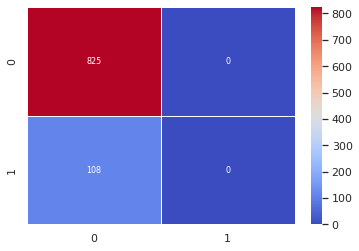

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sn

cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")


In [ ]:
def mean_pooling_last_hidden_state(last_hidden_state, attention_mask):
    # Apply the attention mask to the last hidden state
    attention_mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size())
    last_hidden_state_masked = last_hidden_state * attention_mask

    # Sum the values of the hidden state over the sequence length
    sum_hidden_state = torch.sum(last_hidden_state_masked, 1)

    # Calculate the denominator for the mean pooling operation
    denominator = torch.clamp(torch.sum(attention_mask, 1), min=1e-9)

    # Perform the mean pooling operation
    mean_pooled = sum_hidden_state / denominator

    return mean_pooled

In [ ]:
from sklearn.decomposition import KernelPCA
from sklearn.covariance import MinCovDet

model = RobertaModel.from_pretrained('roberta-base').to(device)

kpca = KernelPCA(n_components=100, kernel='rbf', gamma=0.1)



with torch.no_grad():
  training_data_adv = [np.zeros(768)]
  training_data_clean = [np.zeros(768)]
                                              
  for _, data in tqdm(enumerate(train_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)

        targets = data['labels'].to(device, dtype = torch.long)

        outputs = model(ids, mask)

        outputs = mean_pooling_last_hidden_state(outputs.last_hidden_state, mask).cpu().numpy()

        training_data_adv = np.concatenate((training_data_adv,outputs[data['labels'] > 0.5]), axis = 0)

        training_data_clean = np.concatenate((training_data_clean,outputs[data['labels'] < 0.5]), axis = 0)
        
training_data = np.concatenate((training_data_clean[1:],training_data_adv[1:]) , axis=0)

projected_data = kpca.fit_transform(training_data)
projected_data_adv = kpca.transform(training_data_adv[1:])
projected_data_clean = kpca.transform(training_data_clean[1:])

mcd_adv = MinCovDet()
mcd_clean = MinCovDet()
mcd = MinCovDet()

mcd_adv.fit(projected_data_adv)
mcd_clean.fit(projected_data_clean)
mcd.fit(projected_data)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


MinCovDet()

In [ ]:
metric = load_metric("accuracy")
model.eval()

preds, trues = [], []

with torch.no_grad():

  for _, data in tqdm(enumerate(test_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)

        targets = data['labels'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        outputs = mean_pooling_last_hidden_state(outputs.last_hidden_state, mask).cpu()
        
        projected_data = kpca.transform(outputs)

        distances = mcd_clean.mahalanobis(projected_data), mcd_adv.mahalanobis(projected_data)
        pred = np.argmin(distances, axis = 0)

        metric.add_batch(predictions=pred, references= targets)
      
        preds.extend(pred.tolist())
        trues.extend(data['labels'].cpu().detach().tolist())


metric.compute()

0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

AttributeError: ignored

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten()))

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93       806
         1.0       1.00      0.02      0.05       128

    accuracy                           0.87       934
   macro avg       0.93      0.51      0.49       934
weighted avg       0.88      0.87      0.81       934



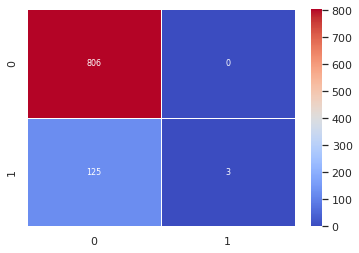

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

In [ ]:
roc_curve(np.array(trues).flatten(), np.array(preds).flatten())

(array([0.        , 0.02255639, 1.        ]),
 array([0.        , 0.02272727, 1.        ]),
 array([2, 1, 0]))